# Team 11: Twitter Sentiment and Bitcoin Prices

**Group Members:**  Andrey Bartashevich (14586517), Finn Prins (13458434), Duco Trompert (14591227)

# Research Question:
 
**Is there a correlation between Twitter (X) posts and Bitcoin price fluctuations or trading volume?**

# Hypothesis: 
**Null hypothesis:** There is no correlation between Twitter (X) posts and changes in Bitcoin prices or trading volume.

**Alternative Hypothesis:** Twitter (X) posts are correlated with changes in Bitcoin prices and trading volume.

**Imports**

In [ ]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from langdetect import detect
from langdetect import DetectorFactory
import re
from wordcloud import WordCloud
from nltk.corpus import stopwords
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.tsa.api import VAR

# Data Processing

**Bitcoin dataset**

First btc price is 2012-01-01
Last btc price is 2024-11-28

First tweet is 2007-04-19
Last tweet is 2019-11-23

Data from 2012-01-01 to 2019-11-23 is valuable

In [ ]:
# Date interval
start_day = "2012-01-01"
end_day = "2019-11-23"

# Open bitcoin csv
bitcoin = pd.read_csv('data/btcusd_1-min_data.csv')
# Renaming timestamp, Close, and Volume columns
bitcoin.rename(columns={'Timestamp': 'date', 'Close': 'price', 'Volume': 'volume'}, inplace=True)
# Make the data column datetime type
bitcoin['date'] = pd.to_datetime(bitcoin['date'], unit='s')
# Convert to datetime and filter by date interval
bitcoin = bitcoin[(bitcoin['date'] >= start_day) & (bitcoin['date'] <= end_day)]
# Convert to daily granularity
bitcoin['date'] = pd.to_datetime(bitcoin['date']).dt.date
bitcoin = bitcoin.groupby('date').agg(
    first_price=('price', 'first'),  # First price of the day
    last_price=('price', 'last'),   # Last price of the day
    price=('price', 'last'),   # Last closing price of the day
    volume=('volume', 'sum')   # Total daily volume
).reset_index()
bitcoin['change'] = bitcoin['last_price'] - bitcoin['first_price']
bitcoin['change'] = bitcoin['change'].fillna(0)
bitcoin = bitcoin[['date', 'price', 'change', 'volume']]


# Print processed Bitcoin data
print(f"Length: {len(bitcoin)}")
print(bitcoin.head())

**Twitter dataset**

In [ ]:
# Open twitter csv
tweet = pd.read_csv('data/tweets_sentiment.csv')
# Sort the dataset
tweet = tweet.sort_values('date').reset_index(drop=True)
# Make the data column datetime type
tweet['date'] = pd.to_datetime(tweet['date'], format='%Y-%m-%d')
# Convert to datetime and filter by date interval
tweet = tweet[(tweet['date'] >= start_day) & (tweet['date'] <= end_day)]

# Print processed Twitter data
print(f"Length: {len(tweet)}")
print(tweet.head())

**Normalized total impressions and sentiment calculation**

In [ ]:
impressions = tweet.groupby('date').agg(
    likes=('likes', 'sum'),  # Sum of likes per day
    replies=('replies', 'sum'),  # Sum of replies per day
    retweets=('retweets', 'sum'),  # Sum of retweets per day
).reset_index()

# Calculate average likes, replies, and retweets
avg_likes = tweet['likes'].mean()
avg_replies = tweet['replies'].mean()
avg_retweets = tweet['retweets'].mean()

# Print average likes, replies, and retweets
print(f"Average likes: {avg_likes}")
print(f"Average replies: {avg_replies}")
print(f"Average retweets: {avg_retweets}")

# Add normalized total impressions
impressions['total'] = 1 / avg_likes * impressions['likes'] + \
                       1 / avg_replies * impressions['replies'] + \
                       1 / avg_retweets * impressions['retweets']

tweet['sentiment'] = (tweet['likes'] / avg_likes +
                      tweet['replies'] / avg_replies +
                      tweet['retweets'] / avg_retweets) * tweet['sentiment']

# Group sentiment by date and assign to impressions
impressions['sentiment'] = tweet.groupby('date')['sentiment'].sum().values


print(f"Length: {len(impressions)}")
print(impressions.head())

**Bitcoin Metrics (impressions, volume, average price**

In [ ]:
# date time conversion
impressions['date'] = pd.to_datetime(impressions['date'])
#only taking year for date
impressions['year'] = impressions['date'].dt.year
bitcoin['date'] = pd.to_datetime(bitcoin['date'])

# calculations of yearly matrices
year_impressions = impressions.groupby('year')['total'].sum().reset_index()
year_volume = bitcoin.groupby(bitcoin['date'].dt.year)['volume'].sum().reset_index()
year_price = bitcoin.groupby(bitcoin['date'].dt.year)['price'].mean().reset_index()

# changing the name of date on year and price
year_volume = year_volume.rename(columns={'date': 'year'})
year_price = year_price.rename(columns={'date': 'year'})

#plot
fig, ax1 = plt.subplots(figsize=(12, 7))
ax2 = ax1.twinx()
ax3 = ax1.twinx()

# prevent overlap on y axis
ax3.spines['right'].set_position(('outward', 60))
# impressions
bars_impressions = ax1.bar(year_impressions['year'], year_impressions['total'],  alpha=0.4, color='blue', label='impressions')
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
#impression bar labels
for i, v in enumerate(year_impressions['total']):
    ax1.text(year_impressions['year'][i], v, round(v, 2), ha='center', va='bottom')

# bitcoin price
line = ax2.plot(year_price['year'], year_price['price'],color='red', label='price')

# volume
bars_volume = ax3.bar(year_volume['year'], year_volume['volume'], alpha=0.4, color='green', label='volume')
ax3.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
#volume bar labels (using scientific notation for visual interpretation)
for i, v in enumerate(year_volume['volume']):
    ax3.text(year_volume['year'][i], v, f'{v:.2e}', ha='center', va='bottom', color='green')

ax1.set_xlabel('Year')
ax1.set_ylabel('Total Impressions', color='blue', alpha=0.7)
ax2.set_ylabel('Average Price', color='red')
ax3.set_ylabel('Volume', color='green')
plt.title('Yearly Bitcoin metrics')
# legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
ax1.legend(lines1 + lines2 + lines3, labels1 + labels2 + labels3, loc='upper left')
plt.show()

**Sentiment analysis (only english text)**

In [ ]:
# seed for result consistency
DetectorFactory.seed = 0

# englsih language checker
def is_english(text):
    try:
        # empty or nan line checker
        if pd.isna(text) or text.strip() == '':
            return False
        # using detect function to find english text
        return detect(text) == 'en'
    except:
         return False


# sentiment analysis using vader library
def vader_sentiment(text):
        #initializing vader module
        analyzer = SentimentIntensityAnalyzer()
        # sentiment scores (compound) from -1 to 1
        scores = analyzer.polarity_scores(text)
        # calculation of sentiment based on the compund score
        # positive
        if scores['compound'] >= 0.05:
            sentiment = 1
        # negative
        elif scores['compound'] <= -0.05:
            sentiment = -1
        # neutral
        else:
            sentiment = 0
        return {'sentiment':sentiment, 'compound':scores['compound']}

***SHould we include the explanation that sentiment analysis was run using ab external python file, since the notebook, could't handle large size of the data???***

**Data visualization**

In [ ]:
#using previously cleaned data from the sentiment analysis and taking 6 mill rows
tweet_sentiment = pd.read_csv('data/tweets_sentiment.csv',nrows=6_000_000)

#cleaning the text using specific characters found in the tweets
def clean_text(s):
    s = re.sub(r'http\S+', '', s)
    s = re.sub('(RT|via)((?:\\b\\W*@\\w+)+)', ' ', s)
    s = re.sub(r'@\S+', '', s)
    s = re.sub('&amp', ' ', s)
    s = re.sub('com', ' ', s)
    s = re.sub(r'[^\x00-\x7F]+', '', s)
    s = re.sub(r'[\u2022\u2023\u2043\u204C\u204D\u2219\u25D8\u25E6\u2619\u2043\u25AA\u25FB]', '', s)
    return s

# dataframe copy
processed_tweets = tweet_sentiment[['text']].copy()
# text cleaning
processed_tweets['cleaned_text'] = processed_tweets['text'].apply(clean_text)
# string with processed text
processed_text = ' '.join(processed_tweets['cleaned_text'].astype(str).str.lower())

# worldcloud visual
wordcloud = WordCloud(
    width=1200,
    height=700,
    collocations=True,
    relative_scaling=0.4,
    stopwords=set(stopwords.words('english'))
).generate(processed_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
def is_stationary(series):
    result = adfuller(series)

    if result[0] < result[4]['5%'] and result[1] < 0.05:
        return True, result[0]
    else:
        return False, result[0]

**Log impressions and log bitcoin price**

In [ ]:

from statsmodels.tsa.stattools import adfuller

date_range = pd.date_range(start=start_day, end=end_day)
date_df = pd.DataFrame({'date': date_range.date})
date_df['date'] = pd.to_datetime(date_df['date'])

impressions['date'] = pd.to_datetime(impressions['date'])
impressions = pd.merge(date_df, impressions, on='date', how='left')
impressions = impressions.fillna(0)

bitcoin['date'] = pd.to_datetime(bitcoin['date'])
bitcoin = pd.merge(date_df, bitcoin, on='date', how='left')
bitcoin = bitcoin.fillna(0)

# Adding 1 to avoid log(0) and interpolting for missing values
log_price = np.log(bitcoin['price'] + 1).interpolate(method='linear')
log_volume = np.log(bitcoin['volume'] + 1).interpolate(method='linear')
log_change = np.log(abs(bitcoin['change']) + 1) * np.sign(bitcoin['change'])
log_impressions = np.log(impressions['total'] + 1).interpolate(method='linear')
log_sentiment = np.log(impressions['sentiment'] + 1).interpolate(method='linear')

adf_price = adfuller(log_price)
adf_volume = adfuller(log_volume)
adf_change = adfuller(log_change)
adf_impressions = adfuller(log_impressions)
adf_sentiment = adfuller(log_sentiment)

print(f"Price ADF: {adf_price[0]}, cutoff: {adf_price[4]}")
print(f"Volume ADF: {adf_volume[0]}, cutoff: {adf_volume[4]}")
print(f"Change ADF: {adf_change[0]}, cutoff: {adf_change[4]}")
print(f"Impressions ADF: {adf_impressions[0]}, cutoff: {adf_impressions[4]}")
print(f"Sentiment ADF: {adf_sentiment[0]}, cutoff: {adf_sentiment[4]}")


# Log Bitcoin price vs log total impressions
plt.figure(figsize=(12, 6))
plt.plot(date_range, log_impressions, label='Log Daily Normalized Total Impressions', color='#ff7f0e')
plt.plot(date_range, log_price, label='Log Bitcoin Daily Price', color='#1f77b4')
plt.legend()
plt.grid(True)
plt.show()

# Log Bitcoin volume vs log total impressions
plt.figure(figsize=(12, 6))
plt.plot(date_range, log_impressions, label='Log Daily Normalized Total Impressions', color='#ff7f0e')
plt.plot(date_range, log_volume, label='Log Bitcoin Daily Volume', color='#1f77b4')
plt.legend()
plt.grid(True)
plt.show()

# Bitcoin change vs log total impressions
plt.figure(figsize=(12, 6))
plt.plot(date_range, log_change, label='Bitcoin Daily Change', color='#1f77b4')
plt.plot(date_range, log_impressions, label='Log Daily Normalized Total Impressions', color='#ff7f0e')
plt.legend()
plt.grid(True)
plt.show()



# Log Bitcoin price vs log sentiment magnitude
plt.figure(figsize=(12, 6))
plt.plot(date_range, log_sentiment, label='Log Daily Normalized Total Impressions', color='#ff7f0e')
plt.plot(date_range, log_price, label='Log Bitcoin Daily Price', color='#1f77b4')
plt.legend()
plt.grid(True)
plt.show()

# Log Bitcoin volume vs log sentiment magnitude
plt.figure(figsize=(12, 6))
plt.plot(date_range, log_sentiment, label='Log Daily Normalized Total Impressions', color='#ff7f0e')
plt.plot(date_range, log_volume, label='Log Bitcoin Daily Volume', color='#1f77b4')
plt.legend()
plt.grid(True)
plt.show()

# Bitcoin change vs log sentiment magnitude
plt.figure(figsize=(12, 6))
plt.plot(date_range, log_change, label='Bitcoin Daily Change', color='#1f77b4')
plt.plot(date_range, log_sentiment, label='Log Daily Normalized Total Impressions', color='#ff7f0e')
plt.legend()
plt.grid(True)
plt.show()

**Pearson correlation coefficient**

The Pearson correlation coefficient (denoted as $r$) is calculated as:

$r = \frac{\text{Cov}(X, Y)}{\sigma_X \cdot \sigma_Y}$

Where:
- $\text{Cov}(X, Y)$ is the covariance between $X$ and $Y$, which measures how much the two variables change together.
- $\sigma_X$ and $\sigma_Y$ are the standard deviations of $X$ and $Y$, which measure the variability in each variable.

Key points:
- Assumes a linear relationship and requires continuous, normally distributed variables.
- Sensitive to outliers.
- $r = 1$ shows a perfect positive linear correlation.
- $r = -1$ shows a perfect negative linear correlation.
- $r = 0$ shows no linear correaltion.

In [ ]:
# Calculate mean
def mean(X):
    return sum(X) / len(X)


# Calculate standard deviation
def standard_deviation(X):
    n = len(X)
    mean_X = mean(X)

    squared_differences = [(x - mean_X)**2 for x in X]

    variance = sum(squared_differences) / n

    std_dev = variance**0.5

    return std_dev


# Calculate covariance
def covariance(X, Y):
    mean_X = mean(X)
    mean_Y = mean(Y)

    deviations_product = [(x - mean_X) * (y - mean_Y) for x, y in zip(X, Y)]

    covariance = sum(deviations_product) / len(X)

    return covariance


# Calculate Pearson correlation coefficient
def pearson_correlation(X, Y):
    covariance_XY = covariance(X, Y)
    std_X = standard_deviation(X)
    std_Y = standard_deviation(Y)
    return covariance_XY / (std_X * std_Y)




In [ ]:
# Calculate and print several Pearson correlation coefficients
pcc = pearson_correlation(log_price, log_impressions)
print(f"The Pearson correlation coefficient between the logarithm of Bitcoin price and the logarithm of normalized total impressions is:\n{pcc}")

pcc = pearson_correlation(log_volume, log_impressions)
print(f"The Pearson correlation coefficient between the logarithm of Bitcoin volume and the logarithm of normalized total impressions is:\n{pcc}")

pcc = pearson_correlation(log_change, log_impressions)
print(f"The Pearson correlation coefficient between the Bitcoin change and the logarithm of normalized total impressions is:\n{pcc}")

pcc = pearson_correlation(log_price, log_sentiment)
print(f"The Pearson correlation coefficient between the logarithm of Bitcoin price and the logarithm of normalized sentiment magnitude is:\n{pcc}")

pcc = pearson_correlation(log_volume, log_sentiment)
print(f"The Pearson correlation coefficient between the logarithm of Bitcoin volume and the logarithm of normalized sentiment magnitude is:\n{pcc}")

pcc = pearson_correlation(log_change, log_sentiment)
print(f"The Pearson correlation coefficient between the Bitcoin change and the logarithm of normalized sentiment magnitude is:\n{pcc}")

**Spearman Rank Correlation**

The Spearman rank correlation coefficient (denoted as $\rho$) measures the strength and direction of a monotonic relationship between two variables.

$\rho = 1 - \frac{6 \sum d_i^2}{n (n^2 - 1)}$

Where:
- $d_i$ is the difference between the ranks of corresponding values in $X$ and $Y$.
- $n$ is the number of data points.

Key points:
- Converts the data to ranks, making it a **non-parametric measure**.
- $\rho = 1$: perfect positive monotonic relationship.
- $\rho = -1$: perfect negative monotonic relationship.
- $\rho = 0$: no monotonic relationship.

In [ ]:
# Rank the data
def rank(data):
    return [sorted(data).index(x) + 1 for x in data]


# Calculate Spearman rank correlation
def spearman_correlation(X, Y):
    n = len(X)
    rank_X = rank(X)
    rank_Y = rank(Y)
    d_squared = [(rx - ry) ** 2 for rx, ry in zip(rank_X, rank_Y)]
    rho = 1 - (6 * sum(d_squared)) / (n * (n**2 - 1))
    return rho


# Calculate and print several Spearman rank correlations
src = spearman_correlation(log_price, log_impressions)
print(f"The Spearman rank correlations between the logarithm of Bitcoin price and the logarithm of normalized total impressions is:\n{src}")

src = spearman_correlation(log_volume, log_impressions)
print(f"The Spearman rank correlations between the logarithm of Bitcoin volume and the logarithm of normalized total impressions is:\n{src}")

src = spearman_correlation(log_change, log_impressions)
print(f"The Spearman rank correlations between the Bitcoin change and the logarithm of normalized total impressions is:\n{src}")

src = spearman_correlation(log_price, log_sentiment)
print(f"The Spearman rank correlations between the logarithm of Bitcoin price and the logarithm of normalized sentiment magnitude is:\n{src}")

src = spearman_correlation(log_volume, log_sentiment)
print(f"The Spearman rank correlations between the logarithm of Bitcoin volume and the logarithm of normalized sentiment magnitude is:\n{src}")

src = spearman_correlation(log_change, log_sentiment)
print(f"The Spearman rank correlations between the Bitcoin change and the logarithm of normalized sentiment magnitude is:\n{src}")

**Kendall Tau Correlation**

The Kendall Tau correlation (denoted as $\tau$) evaluates the degree of concordance between two ranked variables.

$\tau = \frac{C - D}{\frac{1}{2}n(n-1)}$

Where:
- $C$ is the number of concordant pairs (pairs of points $(X_i, Y_i)$ and $(X_j, Y_j)$ where the order is the same).
- $D$ is the number of discordant pairs (pairs of points where the order is reversed).
- $n$ is the total number of points.

Key points:
- A **non-parametric measure** suited for ordinal data.
- $\tau = 1$: perfect agreement in ranks.
- $\tau = -1$: perfect disagreement in ranks.
- $\tau = 0$: no association.

In [ ]:
# Calculate Kendall Tau correlation
def kendall_tau(X, Y):
    n = len(X)
    concordant = 0
    discordant = 0
    for i in range(n):
        for j in range(i + 1, n):
            if (X[i] - X[j]) * (Y[i] - Y[j]) > 0:
                concordant += 1
            elif (X[i] - X[j]) * (Y[i] - Y[j]) < 0:
                discordant += 1
    tau = (concordant - discordant) / (0.5 * n * (n - 1))
    return tau


# Calculate and print several Kendall Tau correlations
ktc = kendall_tau(log_price, log_impressions)
print(f"The Kendall Tau correlation between the logarithm of Bitcoin price and the logarithm of normalized total impressions is:\n{ktc}")

ktc = kendall_tau(log_volume, log_impressions)
print(f"The Kendall Tau correlation between the logarithm of Bitcoin volume and the logarithm of normalized total impressions is:\n{ktc}")

ktc = kendall_tau(log_change, log_impressions)
print(f"The Kendall Tau correlation between the Bitcoin change and the logarithm of normalized total impressions is:\n{ktc}")

ktc = kendall_tau(log_price, log_sentiment)
print(f"The Kendall Tau correlation between the logarithm of Bitcoin price and the logarithm of normalized sentiment magnitude is:\n{ktc}")

ktc = kendall_tau(log_volume, log_sentiment)
print(f"The Kendall Tau correlation between the logarithm of Bitcoin volume and the logarithm of normalized sentiment magnitude is:\n{ktc}")

ktc = kendall_tau(log_change, log_sentiment)
print(f"The Kendall Tau correlation between the Bitcoin change and the logarithm of normalized sentiment magnitude is:\n{ktc}")

**Cross-Correlation**

Cross-correlation quantifies the similarity between two time series $X$ and $Y$ as a function of the lag (shift in time) between them.

$r_\text{lag} = \frac{\sum (X_t - \bar{X})(Y_{t+\text{lag}} - \bar{Y})}{\sqrt{\sum (X_t - \bar{X})^2 \sum (Y_{t+\text{lag}} - \bar{Y})^2}}$

Where:
- $\bar{X}$ and $\bar{Y}$ are the means of $X$ and $Y$, respectively.
- The numerator computes the covariance between $X$ and a lagged version of $Y$.

Key points:
- Often used in signal processing or time series analysis.
- Determines how $X$ and $Y$ relate when one is shifted relative to the other.
- Can identify lead-lag relationships.

In [ ]:
# Calculate Cross-Correlation
def cross_correlation(X, Y, lag):
    n = len(X)
    mean_X = mean(X)
    mean_Y = mean(Y)
    if lag < 0:
        lag = -lag
        X, Y = Y[lag:], X[:-lag]
    else:
        X, Y = X[lag:], Y[:-lag]
    numerator = sum((x - mean_X) * (y - mean_Y) for x, y in zip(X, Y))
    denominator = (sum((x - mean_X) ** 2 for x in X) * sum((y - mean_Y) ** 2 for y in Y)) ** 0.5
    return numerator / denominator


# Plot several Kendall Tau correlations with different lags
max_lag = 1000

plt.figure(figsize=(12, 6))
plt.plot(range(1, max_lag + 1), [cross_correlation(log_price, log_impressions, lag=lag) for lag in range(1, max_lag + 1)], label='Cross-Correlation')
plt.title('Cross-correlation between logarithm of Bitcoin price and the logarithm of normalized total impressions vs. lag ')
plt.xlabel('Lag')
plt.ylabel('Cross-Correlation')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(range(1, max_lag + 1), [cross_correlation(log_volume, log_impressions, lag=lag) for lag in range(1, max_lag + 1)], label='Cross-Correlation')
plt.title('Cross-correlation between logarithm of Bitcoin volume and the logarithm of normalized total impressions vs. lag ')
plt.xlabel('Lag')
plt.ylabel('Cross-Correlation')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(range(1, max_lag + 1), [cross_correlation(log_change, log_impressions, lag=lag) for lag in range(1, max_lag + 1)], label='Cross-Correlation')
plt.title('Cross-correlation between Bitcoin change and the logarithm of normalized total impressions vs. lag ')
plt.xlabel('Lag')
plt.ylabel('Cross-Correlation')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(range(1, max_lag + 1), [cross_correlation(log_price, log_sentiment, lag=lag) for lag in range(1, max_lag + 1)], label='Cross-Correlation')
plt.title('Cross-correlation between logarithm of Bitcoin price and the logarithm of normalized sentiment magnitude vs. lag ')
plt.xlabel('Lag')
plt.ylabel('Cross-Correlation')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(range(1, max_lag + 1), [cross_correlation(log_volume, log_sentiment, lag=lag) for lag in range(1, max_lag + 1)], label='Cross-Correlation')
plt.title('Cross-correlation between logarithm of Bitcoin volume and the logarithm of normalized sentiment magnitude vs. lag ')
plt.xlabel('Lag')
plt.ylabel('Cross-Correlation')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(range(1, max_lag + 1), [cross_correlation(log_change, log_sentiment, lag=lag) for lag in range(1, max_lag + 1)], label='Cross-Correlation')
plt.title('Cross-correlation between Bitcoin change and the logarithm of normalized sentiment magnitude vs. lag ')
plt.xlabel('Lag')
plt.ylabel('Cross-Correlation')
plt.legend()
plt.grid(True)
plt.show()

**Granger Causality Test**

Granger causality tests whether changes in one time series ($X$) can predict changes in another ($Y$), implying a directional causal relationship.

Steps:
1. Fit a restricted model: Regress $Y_t$ on its past values.
2. Fit a full model: Regress $Y_t$ on its past values **and** past values of $X_t$.
3. Compute the F-statistic:

$F = \frac{(RSS_r - RSS_f) / (k_f - k_r)}{RSS_f / (n - k_f)}$

   Where:
   - $RSS_r$: Residual sum of squares from the restricted model.
   - $RSS_f$: Residual sum of squares from the full model.
   - $k_r, k_f$: Number of parameters in restricted and full models.
   - $n$: Number of observations.

Key points:
- More of a  statistical test rather than a measure of correlation.
- Indicates whether $X$ "Granger-causes" $Y$ based on predictive power.
- Does not prove true causation, only predictive influence.

In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests

lag = 100

results = grangercausalitytests(pd.concat([log_price, log_impressions], axis=1), maxlag=lag, verbose=False)
p_values = [results[lag][0]['ssr_ftest'][1] for lag in range(1, lag + 1)]
plt.figure(figsize=(12, 6))
plt.plot(range(1, lag + 1), p_values, label='P-value')
plt.axhline(y=0.05, color='r', linestyle='--', label='Significance Threshold (0.05)')
plt.title('Granger Causality P-values across lags between logarithm of Bitcoin price and the logarithm of normalized total impressions')
plt.xlabel('Lag')
plt.ylabel('P-value')
plt.legend()
plt.grid(True)
plt.show()

results = grangercausalitytests(pd.concat([log_volume, log_impressions], axis=1), maxlag=lag, verbose=False)
p_values = [results[lag][0]['ssr_ftest'][1] for lag in range(1, lag + 1)]
plt.figure(figsize=(12, 6))
plt.plot(range(1, lag + 1), p_values, label='P-value')
plt.axhline(y=0.05, color='r', linestyle='--', label='Significance Threshold (0.05)')
plt.title('Granger Causality P-values across lags between logarithm of Bitcoin volume and the logarithm of normalized total impressions')
plt.xlabel('Lag')
plt.ylabel('P-value')
plt.legend()
plt.grid(True)
plt.show()

results = grangercausalitytests(pd.concat([log_change, log_impressions], axis=1), maxlag=lag, verbose=False)
p_values = [results[lag][0]['ssr_ftest'][1] for lag in range(1, lag + 1)]
plt.figure(figsize=(12, 6))
plt.plot(range(1, lag + 1), p_values, label='P-value')
plt.axhline(y=0.05, color='r', linestyle='--', label='Significance Threshold (0.05)')
plt.title('Granger Causality P-values across lags between Bitcoin change and the logarithm of normalized total impressions')
plt.xlabel('Lag')
plt.ylabel('P-value')
plt.legend()
plt.grid(True)
plt.show()

results = grangercausalitytests(pd.concat([log_price, log_sentiment], axis=1), maxlag=lag, verbose=False)
p_values = [results[lag][0]['ssr_ftest'][1] for lag in range(1, lag + 1)]
plt.figure(figsize=(12, 6))
plt.plot(range(1, lag + 1), p_values, label='P-value')
plt.axhline(y=0.05, color='r', linestyle='--', label='Significance Threshold (0.05)')
plt.title('Granger Causality P-values across lags between logarithm of Bitcoin price and the logarithm of normalized sentiment magnitude')
plt.xlabel('Lag')
plt.ylabel('P-value')
plt.legend()
plt.grid(True)
plt.show()

results = grangercausalitytests(pd.concat([log_volume, log_sentiment], axis=1), maxlag=lag, verbose=False)
p_values = [results[lag][0]['ssr_ftest'][1] for lag in range(1, lag + 1)]
plt.figure(figsize=(12, 6))
plt.plot(range(1, lag + 1), p_values, label='P-value')
plt.axhline(y=0.05, color='r', linestyle='--', label='Significance Threshold (0.05)')
plt.title('Granger Causality P-values across lags between logarithm of Bitcoin volume and the logarithm of normalized sentiment magnitude')
plt.xlabel('Lag')
plt.ylabel('P-value')
plt.legend()
plt.grid(True)
plt.show()

results = grangercausalitytests(pd.concat([log_change, log_sentiment], axis=1), maxlag=lag, verbose=False)
p_values = [results[lag][0]['ssr_ftest'][1] for lag in range(1, lag + 1)]
plt.figure(figsize=(12, 6))
plt.plot(range(1, lag + 1), p_values, label='P-value')
plt.axhline(y=0.05, color='r', linestyle='--', label='Significance Threshold (0.05)')
plt.title('Granger Causality P-values across lags between Bitcoin change and the logarithm of normalized sentiment magnitude')
plt.xlabel('Lag')
plt.ylabel('P-value')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
tweet_test = pd.read_csv('data/tweets_sentiment.csv')

tweet_test = tweet_test.sort_values('date').reset_index(drop=True)
tweet_test['date'] = pd.to_datetime(tweet_test['date']).dt.date

avg_likes = tweet_test['likes'].mean()
avg_replies = tweet_test['replies'].mean()
avg_retweets = tweet_test['retweets'].mean()

(True, -12.392767455949814)
(True, -10.50803293832845)
(True, -10.949153210179839)
(True, -16.203394011725724)
(True, -10.135641244817734)


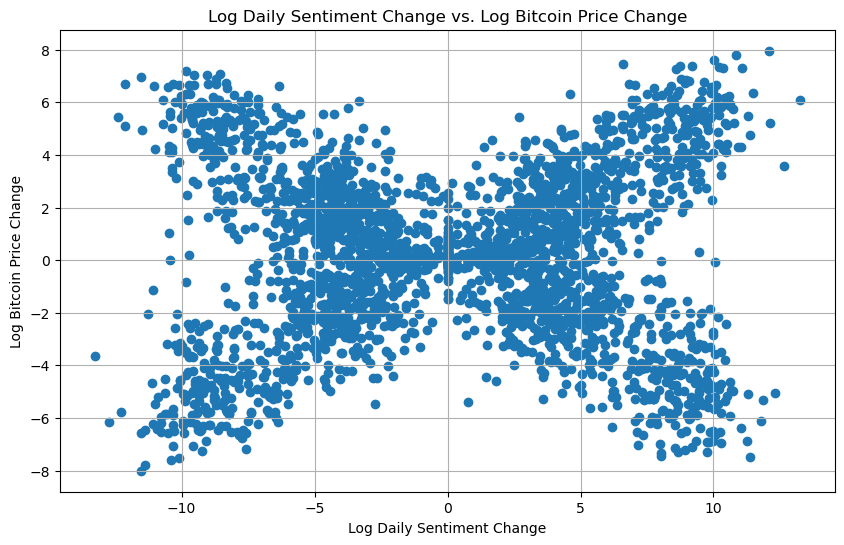

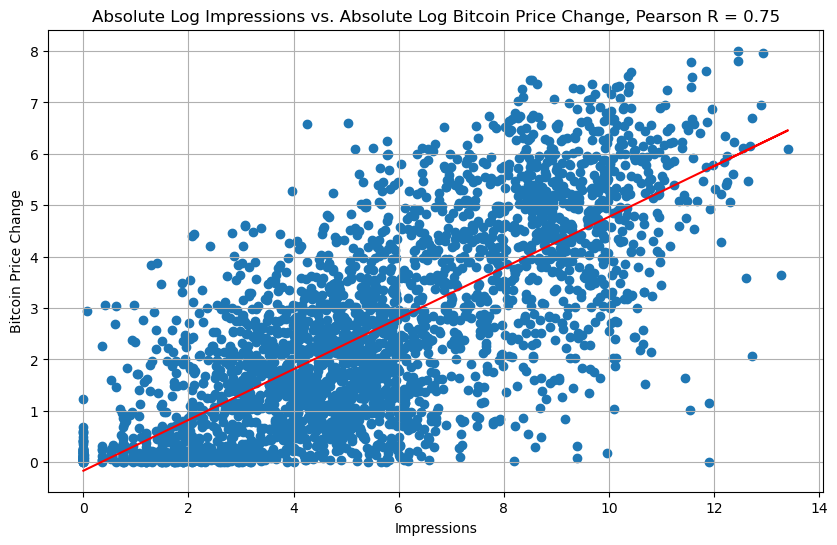

In [209]:
# add a date to impressions
tweet_test['impressions'] = (tweet_test['likes'] / avg_likes + tweet_test['replies'] / avg_replies + tweet_test['retweets'] / avg_retweets)
tweet_test['magnitude'] = tweet_test['impressions'] * tweet_test['sentiment']

daily_impressions = tweet_test.groupby('date')['impressions'].sum().reset_index()
daily_impressions['impressions'] = daily_impressions['impressions'].diff()
daily_impressions = daily_impressions.fillna(0)

daily_magnitude = tweet_test.groupby('date')['magnitude'].sum().reset_index()
daily_magnitude['magnitude'] = daily_magnitude['magnitude'].diff()
daily_magnitude = daily_magnitude.fillna(0)

bitcoin_test = bitcoin[bitcoin['date'].isin(daily_impressions['date'])].reset_index(drop=True)

daily_sentiment = daily_magnitude['magnitude']
bitcoin_change = bitcoin_test['change']

log_bitcoin_change = np.log1p(bitcoin_test['change'].abs()) * np.sign(bitcoin_test['change'])
log_magnitude = np.log1p(daily_magnitude['magnitude'].abs()) * np.sign(daily_magnitude['magnitude'])
log_impressions = np.log1p(daily_impressions['impressions'].abs()) * np.sign(daily_impressions['impressions'])

print(is_stationary(log_bitcoin_change))
print(is_stationary(log_magnitude))
print(is_stationary(log_impressions))
print(is_stationary(daily_magnitude['magnitude']))
print(is_stationary(bitcoin_test['change']))

plt.figure(figsize=(10, 6))
plt.scatter(log_magnitude, log_bitcoin_change)
plt.title('Log Daily Sentiment Change vs. Log Bitcoin Price Change')
plt.xlabel('Log Daily Sentiment Change')
plt.ylabel('Log Bitcoin Price Change')
plt.grid(True)
plt.show()

abs_log_impressions = abs(log_impressions)
abs_log_bitcoin_change = abs(log_bitcoin_change)

linear_correlation = sp.stats.linregress(abs_log_impressions, abs_log_bitcoin_change)

plt.figure(figsize=(10, 6))
plt.scatter(abs_log_impressions, abs_log_bitcoin_change)
plt.plot(abs_log_impressions, linear_correlation.intercept + linear_correlation.slope * abs_log_impressions, color='red')
plt.title(f'Absolute Log Impressions vs. Absolute Log Bitcoin Price Change, Pearson R = {linear_correlation.rvalue:.2f}')
plt.xlabel('Impressions')
plt.ylabel('Bitcoin Price Change')
plt.grid(True)
plt.show()

Best lag for BIC: 8
    forecast       date
0 -13.256550 2019-11-23
1  12.614043 2019-11-24
2 -93.705163 2019-11-25
3  17.003718 2019-11-26
4  12.123043 2019-11-27
5 -21.018020 2019-11-28
6 -32.303462 2019-11-29
7  -0.102251 2019-11-30
8  18.599089 2019-12-01
9   5.692929 2019-12-02


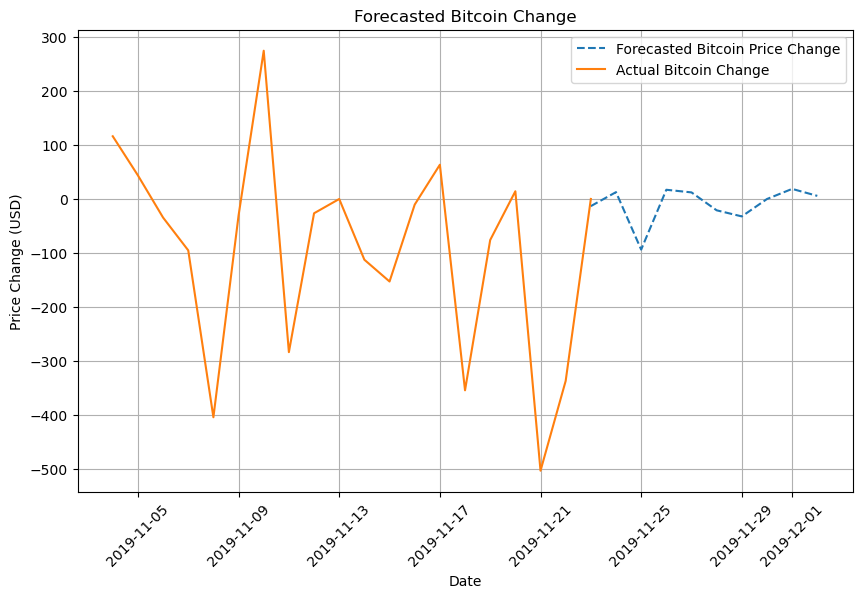

In [210]:
from statsmodels.graphics.tsaplots import plot_pacf

causality_data = pd.concat([bitcoin_change, daily_sentiment], axis=1)

max_lag = 10

model = VAR(causality_data)
lag_order = model.select_order(maxlags=max_lag)

print(f"Best lag for BIC: {lag_order.bic}")

results = model.fit(lag_order.bic)

params = results.params['change']
p_values = results.pvalues['change']

significant_params = params[p_values < 0.05]

forecast_values = results.forecast(causality_data.values, steps=10)[:, 0]

# Get the last date of the Bitcoin data
last_date = bitcoin_test['date'].iloc[-1]

# Create a DataFrame for the forecasted values
forecast_df = pd.DataFrame(forecast_values, columns=['forecast'])

# Generate the forecast dates
forecast_df['date'] = pd.date_range(start=last_date, periods=10, freq='D')  # Adjust 'freq' as needed

print(forecast_df)

plt.figure(figsize=(10, 6))
plt.plot(forecast_df['date'], forecast_df['forecast'], label='Forecasted Bitcoin Price Change', linestyle='--')
plt.plot(bitcoin_test['date'].tail(20), bitcoin_change.tail(20), label='Actual Bitcoin Change')
plt.title('Forecasted Bitcoin Change')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Price Change (USD)')
plt.legend()
plt.grid(True)
plt.show()

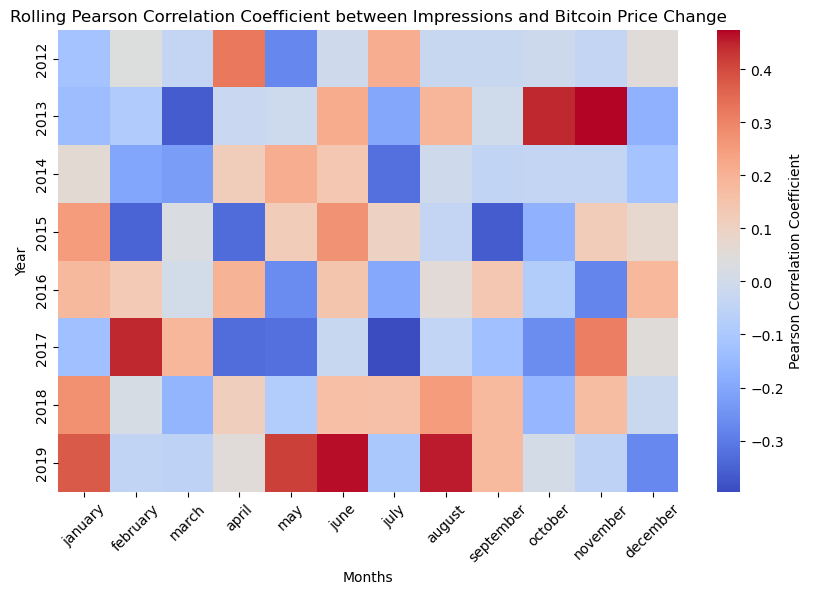

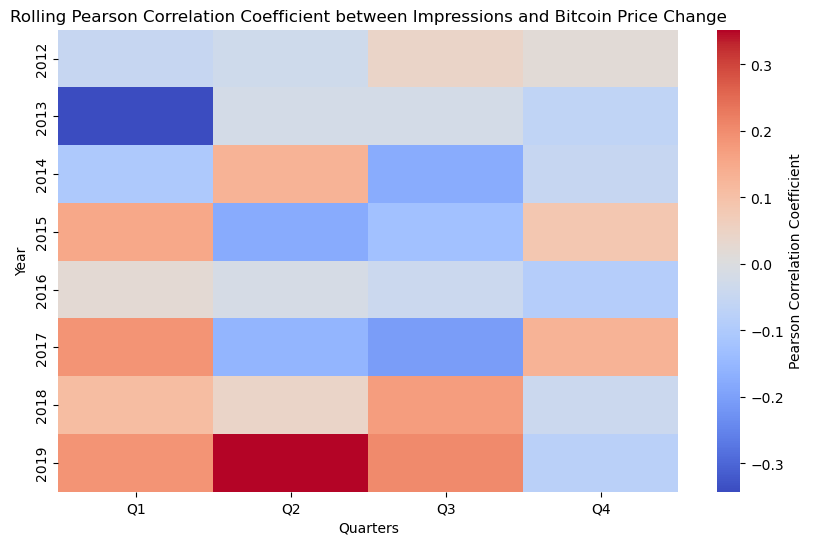

In [211]:
def rolling_window(data1, data2, window_size, step_size, func):
    if not isinstance(data1, (pd.Series, np.ndarray)) or not isinstance(data2, (pd.Series, np.ndarray)):
        raise ValueError("Input data must be pandas Series or numpy arrays.")

    data_array1 = data1.values if isinstance(data1, pd.Series) else data1
    data_array2 = data2.values if isinstance(data2, pd.Series) else data2

    if len(data_array1) != len(data_array2):
        raise ValueError("Both data distributions must have the same length.")

    results = []
    for start in range(0, len(data_array1) - window_size + 1, step_size):
        window1 = data_array1[start:start + window_size]
        window2 = data_array2[start:start + window_size]
        if func:
            results.append(func(window1, window2))

    return results

rolling_months = rolling_window(daily_magnitude['magnitude'], bitcoin_test['change'], window_size=30, step_size=30, func=sp.stats.pearsonr)
rolling_months = [r[0] for r in rolling_months]
rolling_months = np.array(rolling_months).reshape(-1, 12)

rolling_quarters = rolling_window(daily_magnitude['magnitude'], bitcoin_test['change'], window_size=90, step_size=90, func=sp.stats.pearsonr)
rolling_quarters = [r[0] for r in rolling_quarters]
rolling_quarters = np.array(rolling_quarters).reshape(-1, 4)

years = [2012 + i for i in range(rolling_months.shape[0])]
months = ['january', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november', 'december']
quarters = ['Q1', 'Q2', 'Q3', 'Q4']

plt.figure(figsize=(10, 6))
ax = sns.heatmap(rolling_months, cmap='coolwarm', cbar_kws={'label': 'Pearson Correlation Coefficient'})
ax.set_yticklabels(years)
ax.set_xticklabels(months)
plt.xticks(rotation=45)
plt.title('Rolling Pearson Correlation Coefficient between Impressions and Bitcoin Price Change')
plt.xlabel('Months')
plt.ylabel('Year')
plt.show()

plt.figure(figsize=(10, 6))
ax = sns.heatmap(rolling_quarters, cmap='coolwarm', cbar_kws={'label': 'Pearson Correlation Coefficient'})
ax.set_yticklabels(years)
ax.set_xticklabels(quarters)
plt.title('Rolling Pearson Correlation Coefficient between Impressions and Bitcoin Price Change')
plt.xlabel('Quarters')
plt.ylabel('Year')
plt.show()